### Test 6
## Evaluating the quality of POINT-E generated clouds with CAD objects
In this notebook we evaluate the quality of pre-trained POINT-E (300M, 1B) on two datasets:
- ModelNet40
- ShapeNetv0

The evaluation set is generated with a pre-processing procedure documented in another notebook.

In [1]:
from PIL import Image
import torch
from tqdm.auto import tqdm
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import argparse
from sklearn.neighbors import KernelDensity
from scipy.stats import wasserstein_distance
import os

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config

from point_e.evals.feature_extractor import PointNetClassifier, get_torch_devices
from point_e.evals.fid_is import compute_statistics
from point_e.evals.fid_is import compute_inception_score
import math

In [26]:
def views_to_pointcloud(views, n_views=1):
    """ 
        Generate a K-point cloud from a list of n-views
        in:     Tensor(n, w, h, 3), int(n)
        out:    Tensor(1, K, (x, y, z, r, g, b))
    """

    base_name = 'base300M' # base40M, use base300M or base1B for better results

    MODEL_CONFIGS[base_name]["n_views"] = n_views
    MODEL_CONFIGS['upsample']["n_views"] = n_views

    # Instantiate POINT-E and load pre-trained weights
    print('[-] creating base model...')
    base_model = model_from_config(MODEL_CONFIGS[base_name], device)
    base_model.eval()
    base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

    print('[-] creating upsample model...')
    upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
    upsampler_model.eval()
    upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

    print("[-] Loading pretrained models...")
    base_model.load_state_dict(load_checkpoint(base_name, device))
    upsampler_model.load_state_dict(load_checkpoint('upsample', device))

    sampler = PointCloudSampler(
        device=device,
        models=[base_model, upsampler_model],
        diffusions=[base_diffusion, upsampler_diffusion],
        num_points=[num_points, 4096-num_points], # points in cloud and missing ones for upsampling
        aux_channels=['R', 'G', 'B'],
        guidance_scale=[3.0, 3.0],
    )

    # Produce a sample from the model, iterative diffusion process
    samples = None
    for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=views))):
        samples = x

    del sampler
    del base_model
    del base_diffusion
    del upsampler_model
    del upsampler_diffusion

    return samples

# ----------------------------------------------

def cloud_distance(cloud1, cloud2, metric=None):
    """ 
        Compute distance between 1d distributions of cloud p2 norms 
        in:     Tensor((x, y, z), K), Tensor((x, y, z), K) 
        out:    Float
    """
    D1 = torch.cdist(cloud1, cloud1, p=2)
    D2 = torch.cdist(cloud2, cloud2, p=2)
    X1 = [float(1/i.sum()) for i in D1]
    X2 = [float(1/i.sum()) for i in D2]
    
    if metric == "gaussian":
        return np.mean(((np.mean(X1) - np.mean(X2))**2).sum()) / (np.std(X1)**2 + np.std(X2)**2)
    else:
        return wasserstein_distance(X1, X2) * 1e5

# ----------------------------------------------

def plot_distributions(cloud1, cloud2, labels=["cloud1", "cloud2"], idx=0, save_fig=False):
    """ 
        Plot 1d distributions of cloud p2 norms 
        in:     Tensor(K, c), Tensor(K, c) 
    """
    D1 = torch.cdist(cloud1, cloud1, p=2)
    D2 = torch.cdist(cloud2, cloud2, p=2)
    
    s = pd.DataFrame({
        labels[0]: [float(1/i.sum()) for i in D1],
        labels[1]: [float(1/i.sum()) for i in D2],
      })
    s.plot.kde(bw_method=0.4, figsize=(24,8), title=f"Sample {idx} poincloud pdf of different objects")
    
    if save_fig: plt.savefig(f"{idx}_{labels[0]}_{labels[1]}.png")
    
# ----------------------------------------------

def sample_PIS(clf, cloud):
    """
        Compute P-IS score for a cloud
        in:     PointNetClassifier, Tensor(c, K)
        out:    Float
        https://github.com/halixness/point-e/blob/69e677d8ea47593c33fe2f52fd40e131054c9ce3/point_e/evals/fid_is.py#L73
    """
    cloud = cloud.permute(1,0).unsqueeze(0).cpu().numpy()
    _, preds = clf.features_and_preds(cloud)

    return np.exp(
      np.sum(
        preds[0] * ( np.log(preds[0]) - np.log(np.mean(preds[0])) )
      )
    )

# ----------------------------------------------

def batched_PIS(clf, clouds, batch_size=8):
    """
        Computes P-IS score for a batch of point clouds
        in:   PointNetClassifier, (N, K, c)
        out:  Float
    """
    batches = math.ceil(clouds.shape[0] / batch_size)
    dataset_preds = None

    for x in range(batches):
        xs = clouds[(x * batch_size) : ((x + 1) * batch_size)]
        _, preds = clf.features_and_preds(xs)

        if dataset_preds is None: dataset_preds = preds
        else: dataset_preds = np.concatenate((dataset_preds, preds), 0)
            
    return compute_inception_score(dataset_preds)

def batched_PFID(clf, ground_clouds, clouds, batch_size=8):
    """
        Computes P-FID score for pair of batches of point clouds
        in:   PointNetClassifier, (N, K, c), (N, K, c)
        out:  Float
    """
    batches = math.ceil(ground_clouds.shape[0] / batch_size)
    tot_features_1 = None
    tot_features_2 = None

    for x in range(batches):
        
        # Grab batched point clouds to compute the scores
        gnd = ground_clouds[(x * batch_size) : ((x + 1) * batch_size)]
        gen = clouds[(x * batch_size) : ((x + 1) * batch_size)]
        
        features_1, _ = clf.features_and_preds(gnd)
        if tot_features_1 is None: tot_features_1 = features_1
        else: tot_features_1 = np.concatenate((tot_features_1, features_1), 0)
        del features_1

        features_2, _ = clf.features_and_preds(gen)
        if tot_features_2 is None: tot_features_2 = features_2
        else: tot_features_2 = np.concatenate((tot_features_2, features_2), 0)
        del features_2

    stats_1 = compute_statistics(tot_features_1)
    stats_2 = compute_statistics(tot_features_2)    
            
    return stats_1.frechet_distance(stats_2)

**Set-up and data loading**

In [3]:
# Initial parameters 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ToPILImage = transforms.ToPILImage()
num_points = 1024
limit = 1
default_single_view = 0

In [4]:
# Shapenet dataset loading
base_path = os.path.join("..", "..", "..", "Datasets", "shapenet")
views = torch.load(os.path.join(base_path, "images_obj.pt"))
point_clouds = torch.load(os.path.join(base_path, "points.pt"))

ground_objs = []

for i in range(views.shape[0]):
    ground_objs.append([ToPILImage(views[i, j, :, :, :3]) for j in range(4)])

**Generating the point clouds**

In [5]:
# Generate point clouds with point-e in single and multi view mode
gen_clouds = torch.zeros((len(ground_objs), 2, 6, 4096)) # N, 2, c, K

for i, obj in enumerate(ground_objs):
    
    # Point cloud from single view
    print("====== Single view ======")
    gen_clouds[i, 0, :, :] = views_to_pointcloud(views = [obj[default_single_view]], n_views = 1)

    torch.cuda.empty_cache()

    # Point cloud from multi view
    print("\n====== Multi view ======")
    gen_clouds[i, 1, :, :] = views_to_pointcloud(views = obj, n_views = len(obj))
    
    torch.cuda.empty_cache()
    
    if limit != -1 and i == limit: break

====== Single view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]


====== Multi view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*4 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*4 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]

====== Single view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]


====== Multi view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*4 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*4 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]

### A note on metrics:
- **P-FID** is the PointCloud-[Fréchet Inception Distance](https://en.wikipedia.org/wiki/Fréchet_inception_distance), that is the distance between the distance between the distribution of original samples and the distribution of the generated ones, based on the logits from the last lasters of the Inception v3 network.
- **P-IS** is the PointCloud-[Inception Score](https://en.wikipedia.org/wiki/Inception_score), which is normally computed to measure the quality of a distribution of synthetic images. The score is maximized when the entropy given the predictions is minimal, that is the prediction is very sharp on a single label. To compute the prediction, an improved version of [PointNet](https://arxiv.org/abs/1612.00593), a 3d point clouds classifier, is used.
- **[Wassetstein distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html)**: or Earth mover's distance, the distance between two sets of samples. In this case, a set of samples is computed from a single point cloud and it represents the distance from each point to all the others in the cloud (sum for 1d, otherwise a KxK matrix).

In [6]:
# Load PointNet to classify point clouds (and derive semantic score)
clf = PointNetClassifier(devices=get_torch_devices(), cache_dir=None)


====== [0] Point cloud divergences ======
[+] Ground truth - Single view divergence: 		29.493687924997403
[+] Ground truth - Multi view divergence: 		57.528445948662466
[+] Single view - Multi view divergence: 		87.02213387365987

====== [1] Point cloud divergences ======
[+] Ground truth - Single view divergence: 		4.278875539398541
[+] Ground truth - Multi view divergence: 		13.096723957062295
[+] Single view - Multi view divergence: 		8.817848417663754


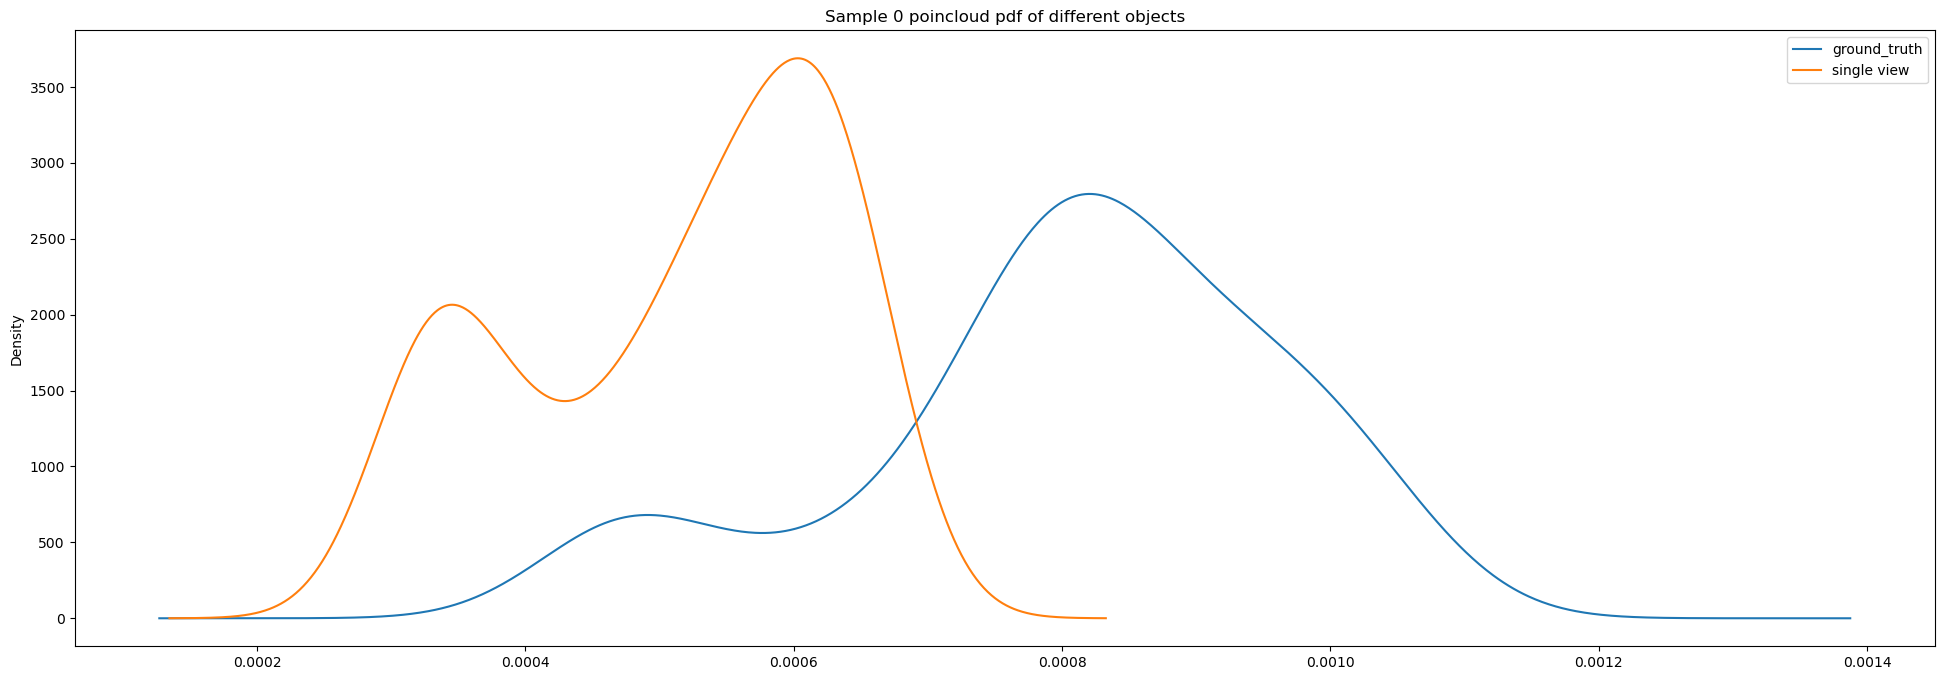

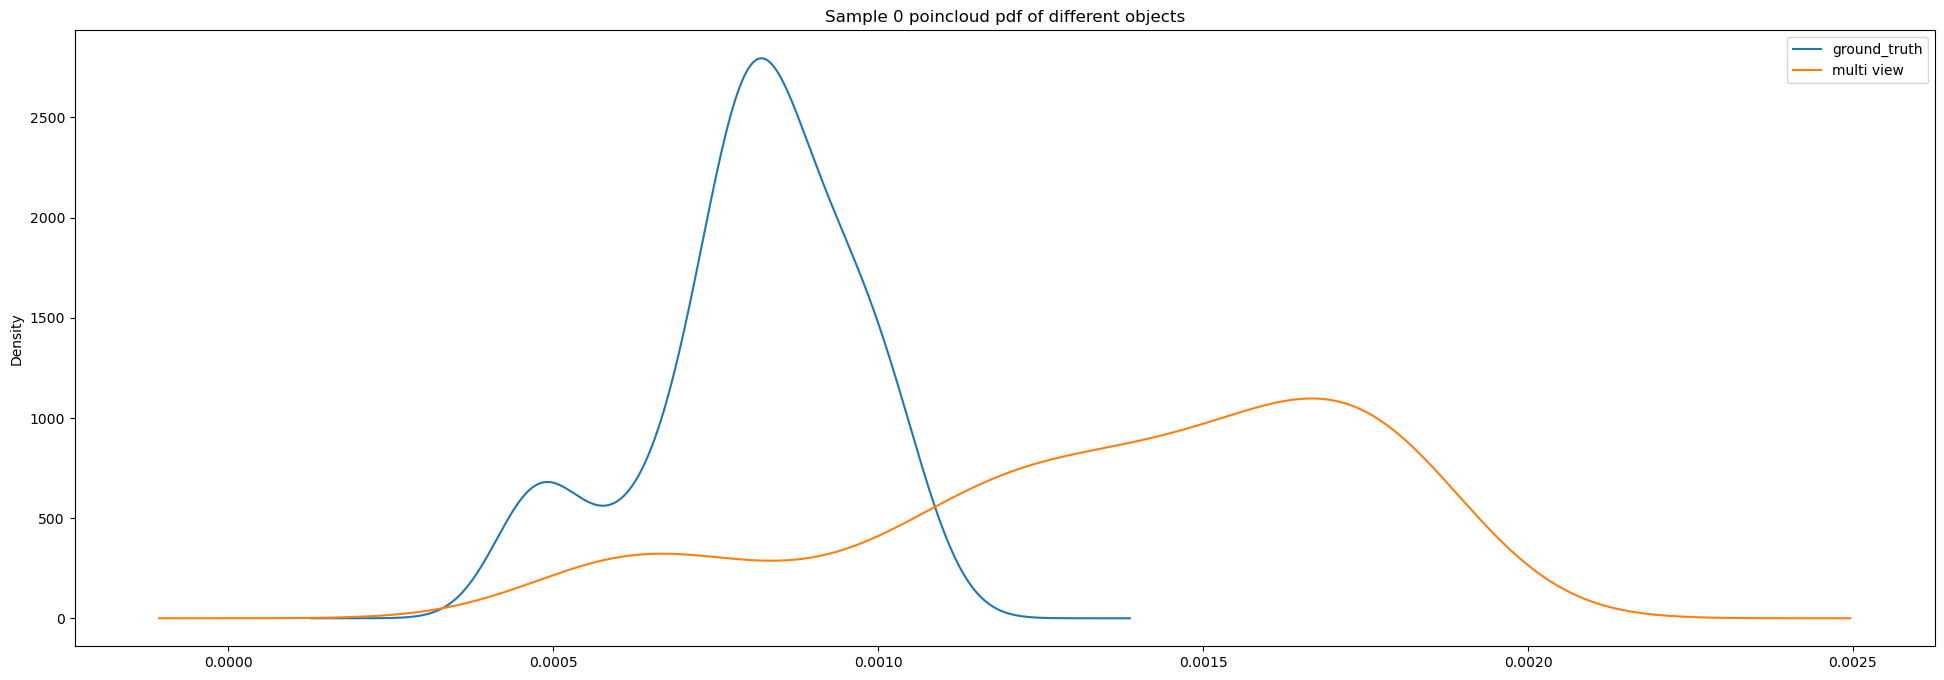

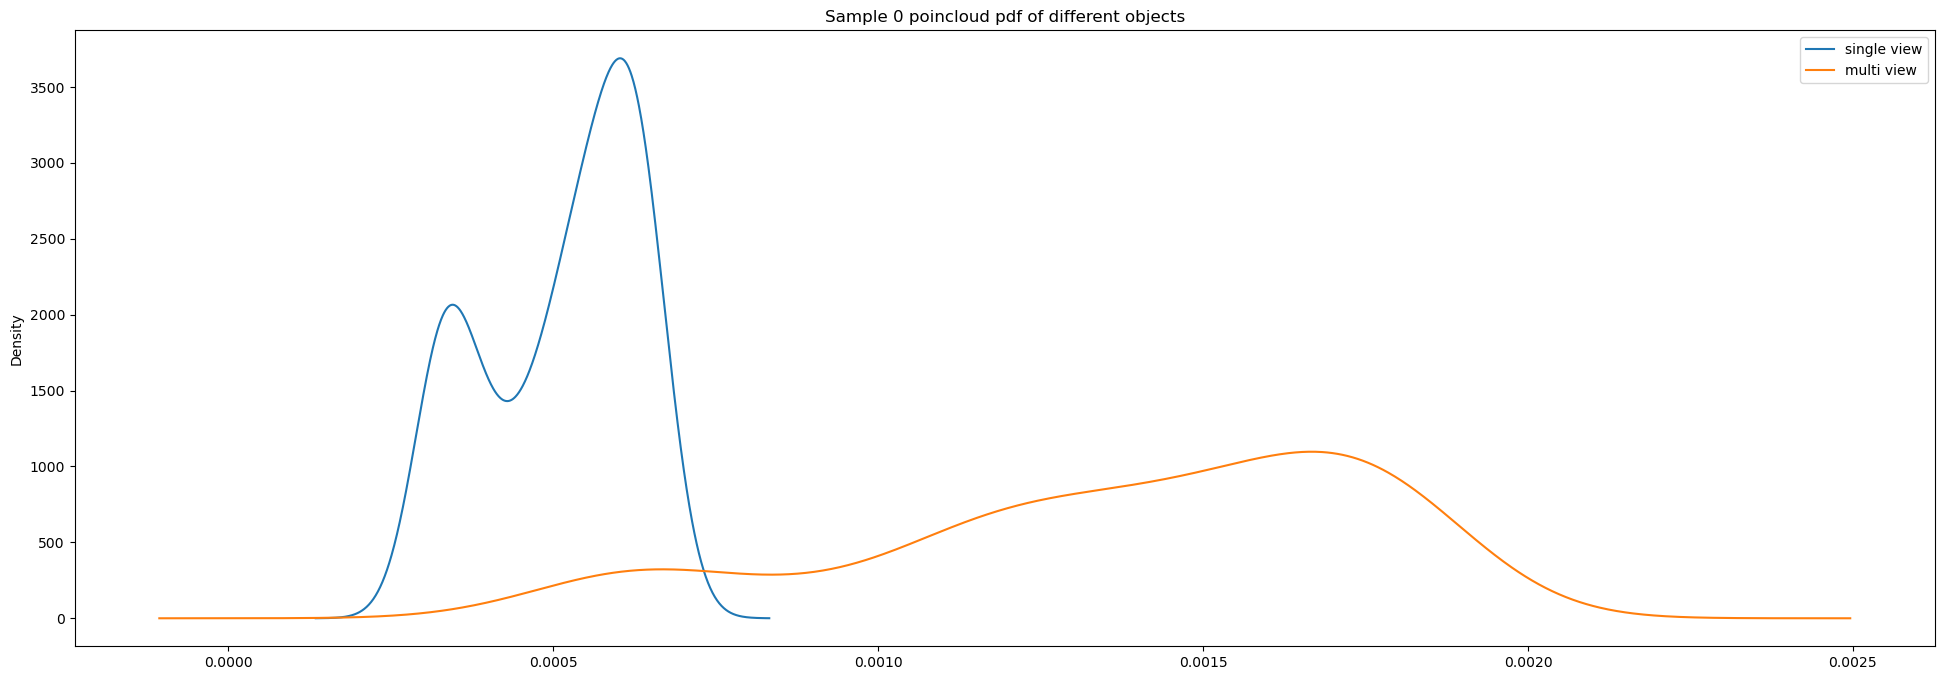

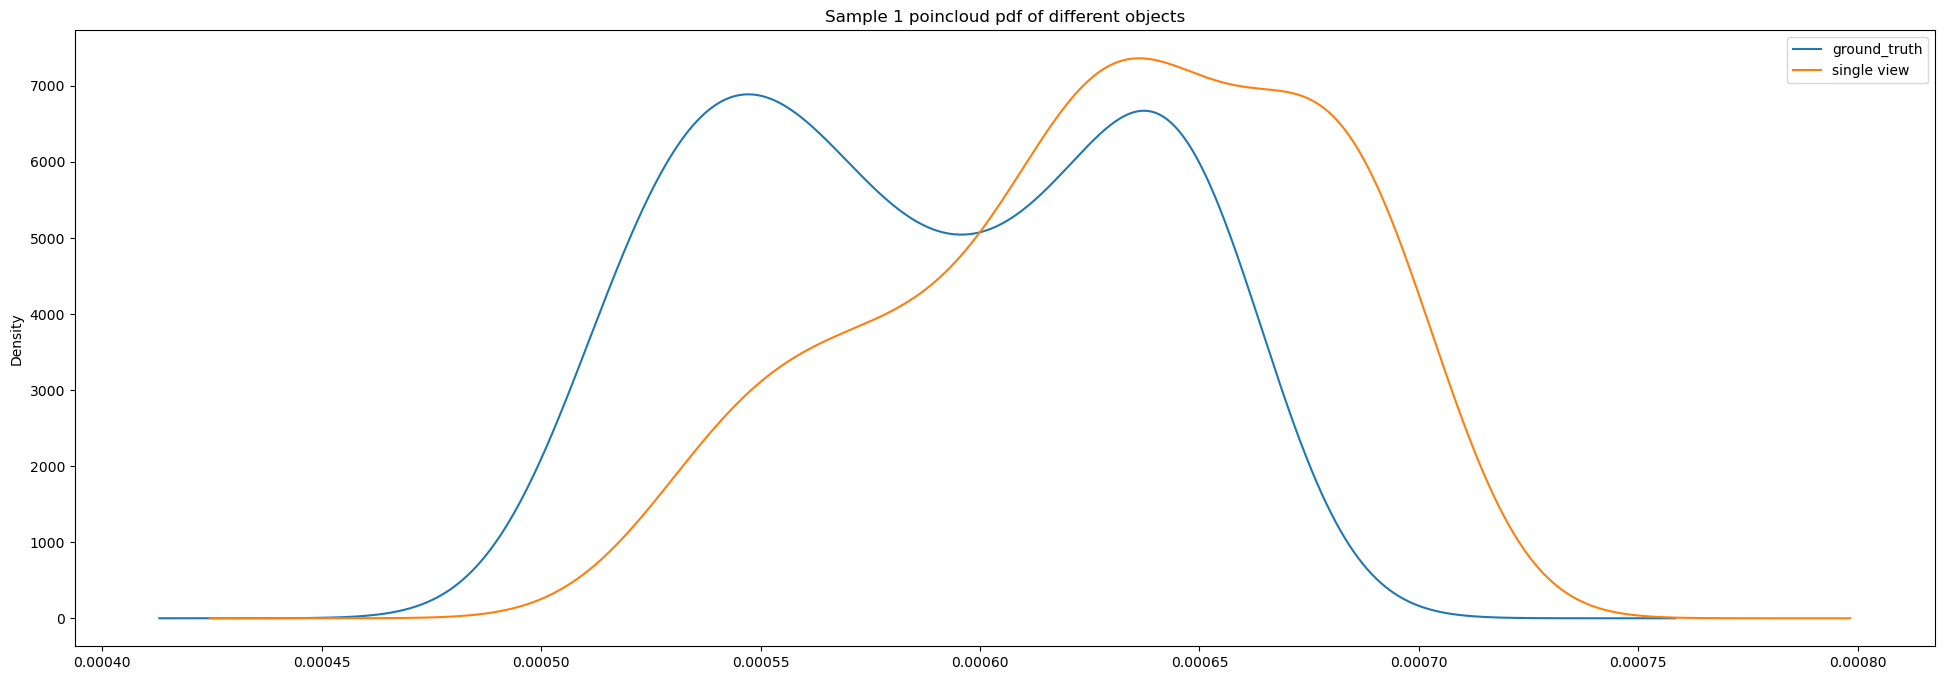

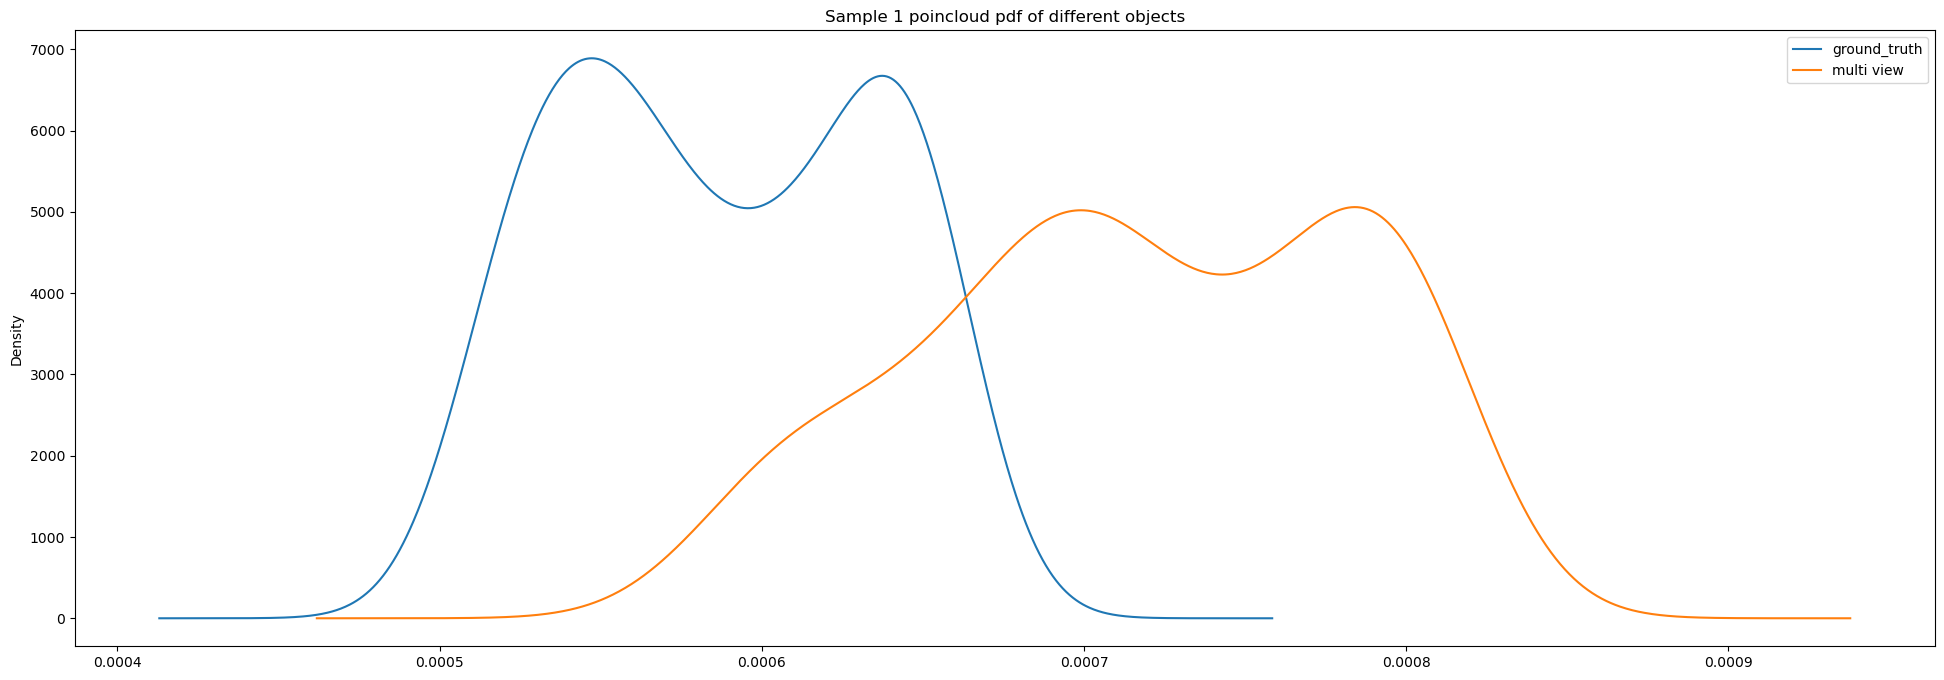

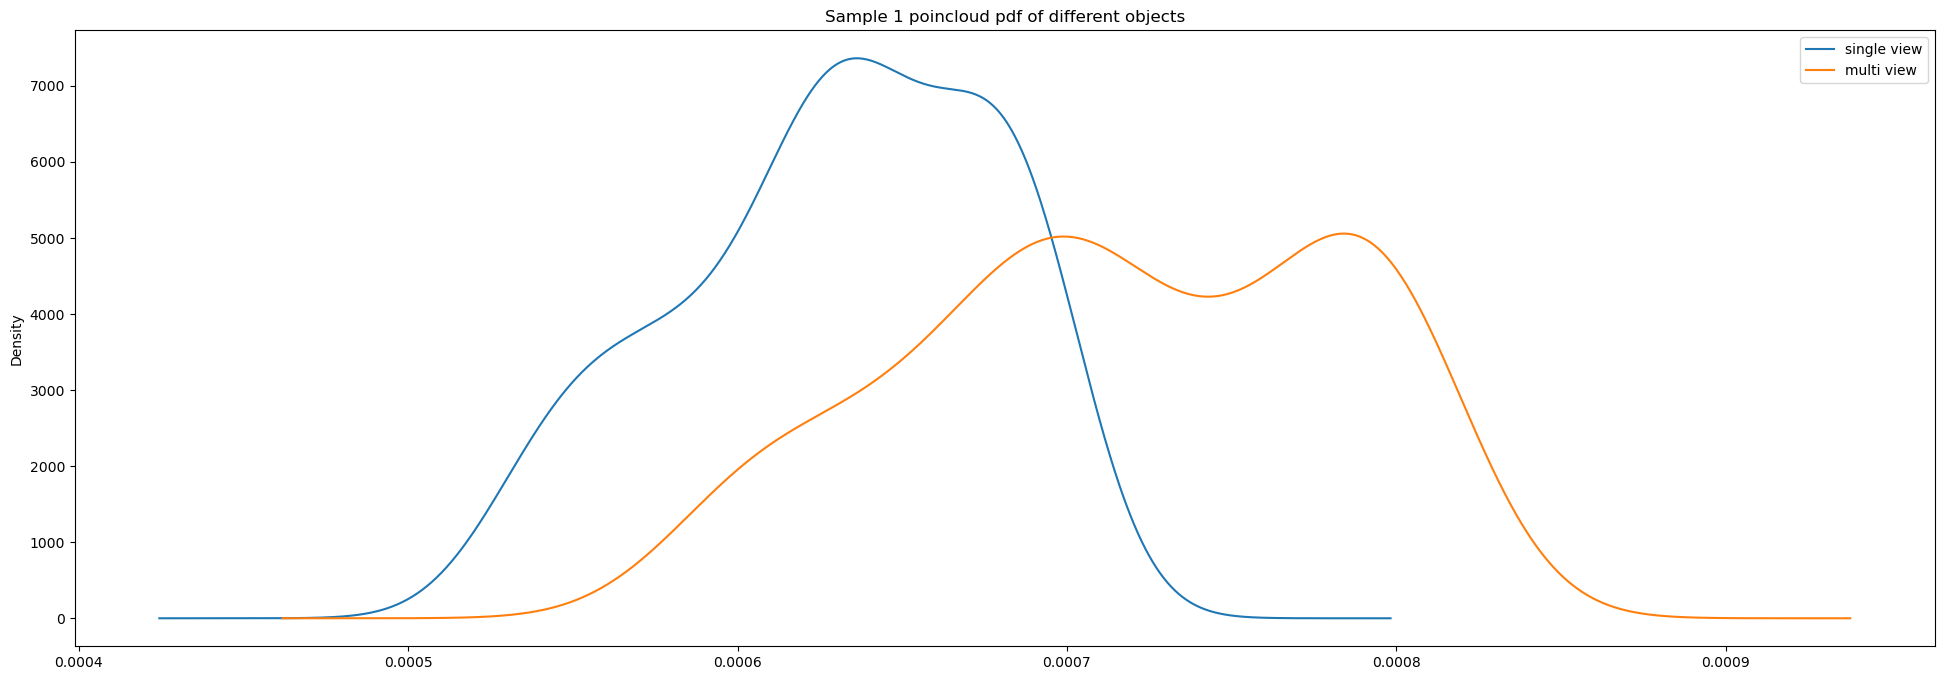

In [7]:
scores = torch.zeros((gen_clouds.shape[0], 3))

for i in range(gen_clouds.shape[0]):
    
    print(f"\n====== [{i}] Point cloud divergences ======")
    
    # ---- ground truth cloud / single view cloud
    d_ground_single = cloud_distance(
        torch.Tensor(point_clouds[i]), 
        gen_clouds[i, 0, :3, :].permute(1,0)
    )
    
    print("[+] Ground truth - Single view divergence: \t\t{}".format(d_ground_single))

    plot_distributions(
        torch.Tensor(point_clouds[i]),
        gen_clouds[i, 0, :3, :].permute(1,0),
        ["ground_truth", "single view"], 
        i
    )

    # ---- ground truth cloud / multi view cloud
    d_ground_multi = cloud_distance(
        torch.Tensor(point_clouds[i]), 
        gen_clouds[i, 1, :3, :].permute(1,0)
    )
    print("[+] Ground truth - Multi view divergence: \t\t{}".format(d_ground_multi))

    plot_distributions(
        torch.Tensor(point_clouds[i]),
        gen_clouds[i, 1, :3, :].permute(1,0),
        ["ground_truth", "multi view"], 
        i
    )

    # ---- single view cloud / multi view cloud
    d_single_multi = cloud_distance(
        gen_clouds[i, 0, :3, :].permute(1,0), 
        gen_clouds[i, 1, :3, :].permute(1,0)
    )
    print("[+] Single view - Multi view divergence: \t\t{}".format(d_single_multi))

    plot_distributions(
        gen_clouds[i, 0, :3, :].permute(1,0), 
        gen_clouds[i, 1, :3, :].permute(1,0), 
        ["single view", "multi view"], 
        i
    )
    
    scores[i, :] = torch.Tensor([d_ground_single, d_ground_multi, d_single_multi])
    
    if limit != -1 and i == limit: break

**Note:** depending on the choice of the single view and the number of similar objects seen during training, POINT-E can guess the surface of occluded parts correctly or not. Moreover, POINT-E has not been fine-tuned on multiple views yet, it could learn to exploit information from multiple frames for better 3d consistency.

In [15]:
limit = gen_clouds.shape[0] if limit == -1 else limit+1

In [17]:
ground_PIS = batched_PIS(clf, point_clouds[:limit])
single_PIS = batched_PIS(clf, gen_clouds[:limit, 0, :3, :].permute(0, 2, 1).cpu().numpy())
multi_PIS = batched_PIS(clf, gen_clouds[:limit, 1, :3, :].permute(0, 2, 1).cpu().numpy())

print(f"[+] Ground truth clouds PIS: \t\t\t{ground_PIS}")
print(f"[+] Single-view generated clouds PIS: \t\t{single_PIS}")
print(f"[+] Multi-view generated clouds PIS: \t\t{multi_PIS}")

[+] Ground truth clouds PIS: 			1.991499423980713
[+] Single-view generated clouds PIS: 		1.9791995286941528
[+] Multi-view generated clouds PIS: 		1.845573902130127


In [27]:
ground_single_PFID = batched_PFID(clf, 
    point_clouds[:limit],
    gen_clouds[:limit, 0, :3, :].permute(0, 2, 1).cpu().numpy()                  
)
ground_multi_PFID = batched_PFID(clf, 
    point_clouds[:limit],
    gen_clouds[:limit, 1, :3, :].permute(0, 2, 1).cpu().numpy()
)

print(f"[+] Ground truth - single view P-FID: \t\t{ground_single_PFID}")
print(f"[+] Ground truth - multi view P-FID: \t\t{ground_multi_PFID}")

[+] Ground truth - single view P-FID: 		113.82087352997763
[+] Ground truth - multi view P-FID: 		100.4728541603944
